In [1]:
import numpy as np
from celerite.terms import Matern32Term, RealTerm
from mind_the_gaps.models.celerite.celerite_models import Lorentzian
from mind_the_gaps.simulator import Simulator
from mind_the_gaps.lightcurves import GappyLightcurve
import matplotlib.pyplot as plt
from mind_the_gaps import GPModelling
from mind_the_gaps.utils.stats import aicc
from scipy.stats import norm, ks_1samp
from mind_the_gaps.models.kernel_spec import (
    KernelParameterSpec,
    KernelSpec,
    KernelTermSpec,
)

import corner
plt.rcParams['figure.figsize'] = [16, 8]
np.random.seed(10)

/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Let's first generate a lightcurve with a complex PSD, a combination of a DRW, Matern-3/2 and a QPO (Lorentzian)

log variance of the QPO: 4.61, log_Q: 4.38, log omega: -1.38


/Users/connorourke/miniconda3/envs/mind_the_gaps/lib/python3.11/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


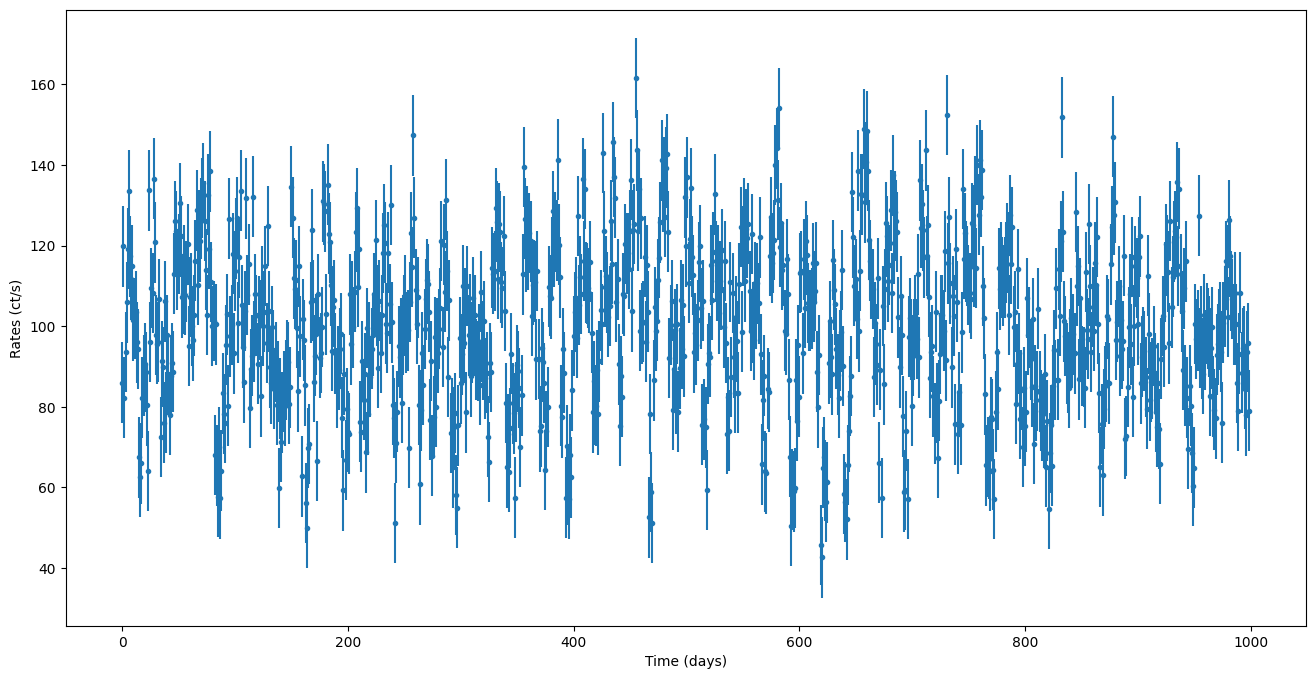

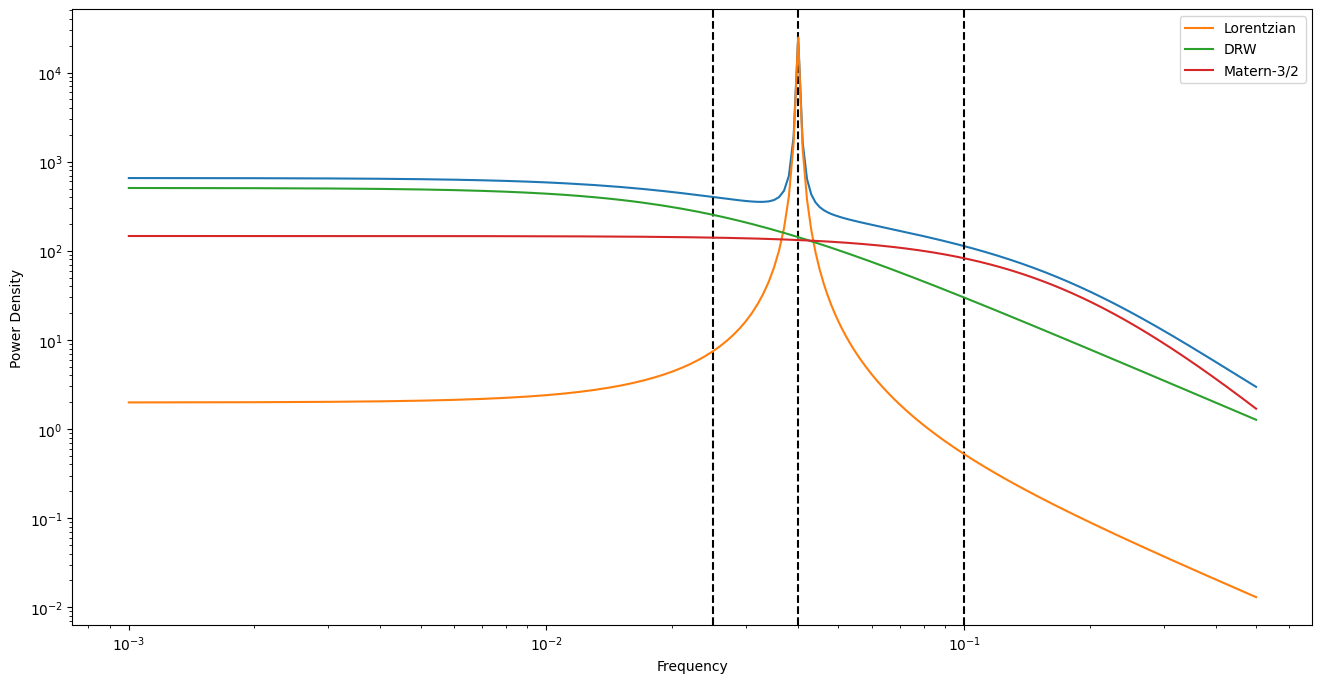

In [2]:
times  = np.arange(0, 1000)
exposure = np.diff(times)[0]

P_qpo = 25 # period of the QPO
w = 2 * np.pi / P_qpo
mean = 100
rms = 0.1
variance_drw = (mean * rms) ** 2  # variance of the DRW (bending powerlaw)
P_drw = 40
w_bend = 2 * np.pi / P_drw # angular frequency of the DRW or Bending Powerlaw
# Define starting parameters
log_variance_qpo = np.log(variance_drw)
log_sigma_matern = np.log(np.sqrt(variance_drw))
P_matern = 10
log_rho_matern =  np.log(P_matern / 2 / np.pi)
Q = 80 # coherence
log_Q = np.log(Q)
log_d = np.log(w)
print(f"log variance of the QPO: {log_variance_qpo:.2f}, log_Q: {log_Q:.2f}, log omega: {log_d:.2f}")

labels = ["Lorentzian", "DRW", "Matern-3/2"]
# You can also use Lorentzian from models.celerite_models (which is defined in terms of variance, Q and omega)
kernel = Lorentzian(log_S0=log_variance_qpo, log_Q=np.log(Q), log_omega0=log_d) \
     + RealTerm(log_a=np.log(variance_drw), log_c=np.log(w_bend)) + Matern32Term(log_sigma_matern, 
                                                                                log_rho_matern, eps=1e-8)



kernel_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=Lorentzian,
                parameters={
                    "log_S0": KernelParameterSpec(
                        value=log_variance_qpo, bounds=(-10, 50)
                    ),
                    "log_Q": KernelParameterSpec(value=np.log(Q), bounds=(-10, 10)),
                    "log_omega0": KernelParameterSpec(value=log_d, bounds=(-5, 5)),
                },
            ),   KernelTermSpec(
                term_class=RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=np.log(variance_drw), bounds=(-10, 50)
                    ),
                    "log_c": KernelParameterSpec(value=np.log(w_bend), bounds=(-10, 10)),
                }),
            KernelTermSpec(
                term_class=Matern32Term,
                parameters={
                    "log_sigma": KernelParameterSpec(
                        value=log_sigma_matern, bounds=(-10, 50)
                    ),
                    "log_rho": KernelParameterSpec(value=log_rho_matern, bounds=(-10, 10)),
                },
            eps=1e-8
            )
            ]

    )
kernel = kernel_spec.get_kernel()
truth = kernel.get_parameter_vector()
psd_model = kernel.get_psd

# create simulator object with Gaussian noise
simulator = Simulator(psd_model, times, np.ones(len(times)) * exposure, mean, pdf="Gaussian", 
                      sigma_noise=10, extension_factor = 2)

# simulate noiseless count rates from the PSD, make the initial lightcurve 2 times as long as the original times
countrates = simulator.generate_lightcurve()
# add (Poisson) noise
noisy_countrates, dy = simulator.add_noise(countrates)
input_lc = GappyLightcurve(times, noisy_countrates, dy, exposures=exposure)

fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")

# plot PSD
df = 1 / input_lc.duration
nyquist = 1 / (2 * exposure)
freqs = np.arange(df, nyquist, df)
fig = plt.figure()
# remember angular freqs for the PSD models
plt.plot(freqs, psd_model(2 * np.pi * freqs))
for p in [P_qpo, P_drw, P_matern]:
    plt.axvline(1 / p, ls="--", color="black")

plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.xscale("log")
plt.yscale("log")
for i, term in enumerate(kernel.terms):
    plt.plot(freqs, term.get_psd(2 * np.pi * freqs), label=labels[i])
plt.legend()

lc_variance = np.var(input_lc.y)

Dummy methods to construct reasonable parameter bounds

In [3]:
def bounds_variance(variance, margin=15):
    return np.log(variance/margin), np.log(variance * margin)

def bounds_bend(duration, dt):
    nyquist = 1 / (2 * dt)
    return np.log(2 * np.pi/duration), np.log(nyquist * 2 * np.pi)

# Define models to be tested and their bounds based on the data

In [4]:
variance_bounds = bounds_variance(lc_variance)
print(variance_bounds)
bend_bounds = bounds_bend(input_lc.duration, exposure)
print(bend_bounds)
sigma_bounds = bounds_variance(np.sqrt(lc_variance))
timescale_bounds = ((np.log(exposure), np.log(input_lc.duration)))
print(timescale_bounds)
# limit Q lower bound to "periodic" components
Q_bounds = (np.log(1.5), np.log(1000))

log_var = np.log(lc_variance)
real_spec = KernelSpec(
        terms=[
            KernelTermSpec(
                term_class=RealTerm,
                parameters={
                    "log_a": KernelParameterSpec(
                        value=log_var, bounds=variance_bounds
                    ),
                    "log_c": KernelParameterSpec(value=np.log(2 * np.pi / 50), bounds=bend_bounds),
                },
            )])
lorentzian_spec =  KernelSpec(
        terms=[KernelTermSpec(
                term_class=Lorentzian,
                parameters={
                    "log_S0": KernelParameterSpec(
                        value=log_var, bounds=variance_bounds
                    ),
                    "log_Q": KernelParameterSpec(value=np.log(100), bounds=Q_bounds),
                    "log_omega0": KernelParameterSpec(value=np.log(2 * np.pi/10), bounds=bend_bounds),
                },
            )])
matern_spec = KernelSpec(
        terms=[KernelTermSpec(
                term_class=Matern32Term,
                parameters={
                    "log_sigma": KernelParameterSpec(
                        value=np.log(np.sqrt(lc_variance)), bounds=sigma_bounds
                    ),
                    "log_rho": KernelParameterSpec(value=np.log(10), bounds=timescale_bounds),
                },
            eps=1e-8
            )])

models = [real_spec, 
          matern_spec,
         lorentzian_spec + real_spec,
         lorentzian_spec + real_spec + matern_spec
          ,]

(3.3052094097136107, 8.721309811918031)
(-5.068877712239209, 1.1447298858494002)
(0.0, 6.906754778648554)


# Derive AICc and p-values for the standarized residuals following a normal (0, 1) distribution

In [5]:
cpus = 12
aiccs = []
pvalues = []
gps = []
for kernel_spec in models:
    print(kernel)
    print("------------------------------------------------------------------")
    gp = GPModelling( kernel_spec=kernel_spec, lightcurve=input_lc, fit_mean=False)
    # here we first minimize the likelihood and then run a small MCMC to ensure we find the maximum of the loglikelihood
    gp.derive_posteriors(fit=True, max_steps=2000, walkers=2 * cpus, cores=cpus, progress=False)
    best_pars = gp.max_parameters
    gp.parameters = best_pars
    std_res = gp.standarized_residuals()
    pvalue = ks_1samp(std_res, norm.cdf).pvalue
    AICc = aicc(gp.max_loglikelihood, gp.k, input_lc.n)
    print(f"p-value:{pvalue:.3f} | AICC: {AICc:.2f}")
    pvalues.append(pvalue)
    aiccs.append(AICc)
    gps.append(gp)
    

(Lorentzian(4.605170185988092, 4.382026634673881, -1.3809987584588552) + RealTerm(4.605170185988092, -1.851002387704591) + Matern32Term(2.302585092994046, 0.4647080265847003, eps=1e-08))
------------------------------------------------------------------
p-value:0.707 | AICC: 8264.18
(Lorentzian(4.605170185988092, 4.382026634673881, -1.3809987584588552) + RealTerm(4.605170185988092, -1.851002387704591) + Matern32Term(2.302585092994046, 0.4647080265847003, eps=1e-08))
------------------------------------------------------------------


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite_engine.py:205: UserWarning: The chains did not converge after 2000 iterations!
  warnings.warn(


p-value:0.000 | AICC: 8250.67
(Lorentzian(4.605170185988092, 4.382026634673881, -1.3809987584588552) + RealTerm(4.605170185988092, -1.851002387704591) + Matern32Term(2.302585092994046, 0.4647080265847003, eps=1e-08))
------------------------------------------------------------------
p-value:0.057 | AICC: 8162.80
(Lorentzian(4.605170185988092, 4.382026634673881, -1.3809987584588552) + RealTerm(4.605170185988092, -1.851002387704591) + Matern32Term(2.302585092994046, 0.4647080265847003, eps=1e-08))
------------------------------------------------------------------


/Users/connorourke/bin/src/TEMP_MTG/mind_the_gaps/mind_the_gaps/engines/celerite_engine.py:297: UserWarning: Some walkers are out of bounds! Setting them to values close to the bounds
  warnings.warn(


p-value:0.004 | AICC: 8156.94


# Finally our best-fit model is that which minimizes the AICc

[ 4.97719378  4.5852122  -1.37973754  4.37606993 -0.77923644  2.31149581
  1.25730114]
Best model KernelSpec(terms=[KernelTermSpec(term_class=<class 'mind_the_gaps.models.celerite.celerite_models.Lorentzian'>, parameters=OrderedDict([('log_S0', KernelParameterSpec(value=6.013259610815821, fixed=False, prior=None, bounds=(3.3052094097136107, 8.721309811918031))), ('log_Q', KernelParameterSpec(value=4.605170185988092, fixed=False, prior=None, bounds=(0.4054651081081644, 6.907755278982137))), ('log_omega0', KernelParameterSpec(value=-0.46470802658470023, fixed=False, prior=None, bounds=(-5.068877712239209, 1.1447298858494002)))])), KernelTermSpec(term_class=<class 'celerite.terms.RealTerm'>, parameters=OrderedDict([('log_a', KernelParameterSpec(value=6.013259610815821, fixed=False, prior=None, bounds=(3.3052094097136107, 8.721309811918031))), ('log_c', KernelParameterSpec(value=-2.0741459390188006, fixed=False, prior=None, bounds=(-5.068877712239209, 1.1447298858494002)))])), KernelTermSp

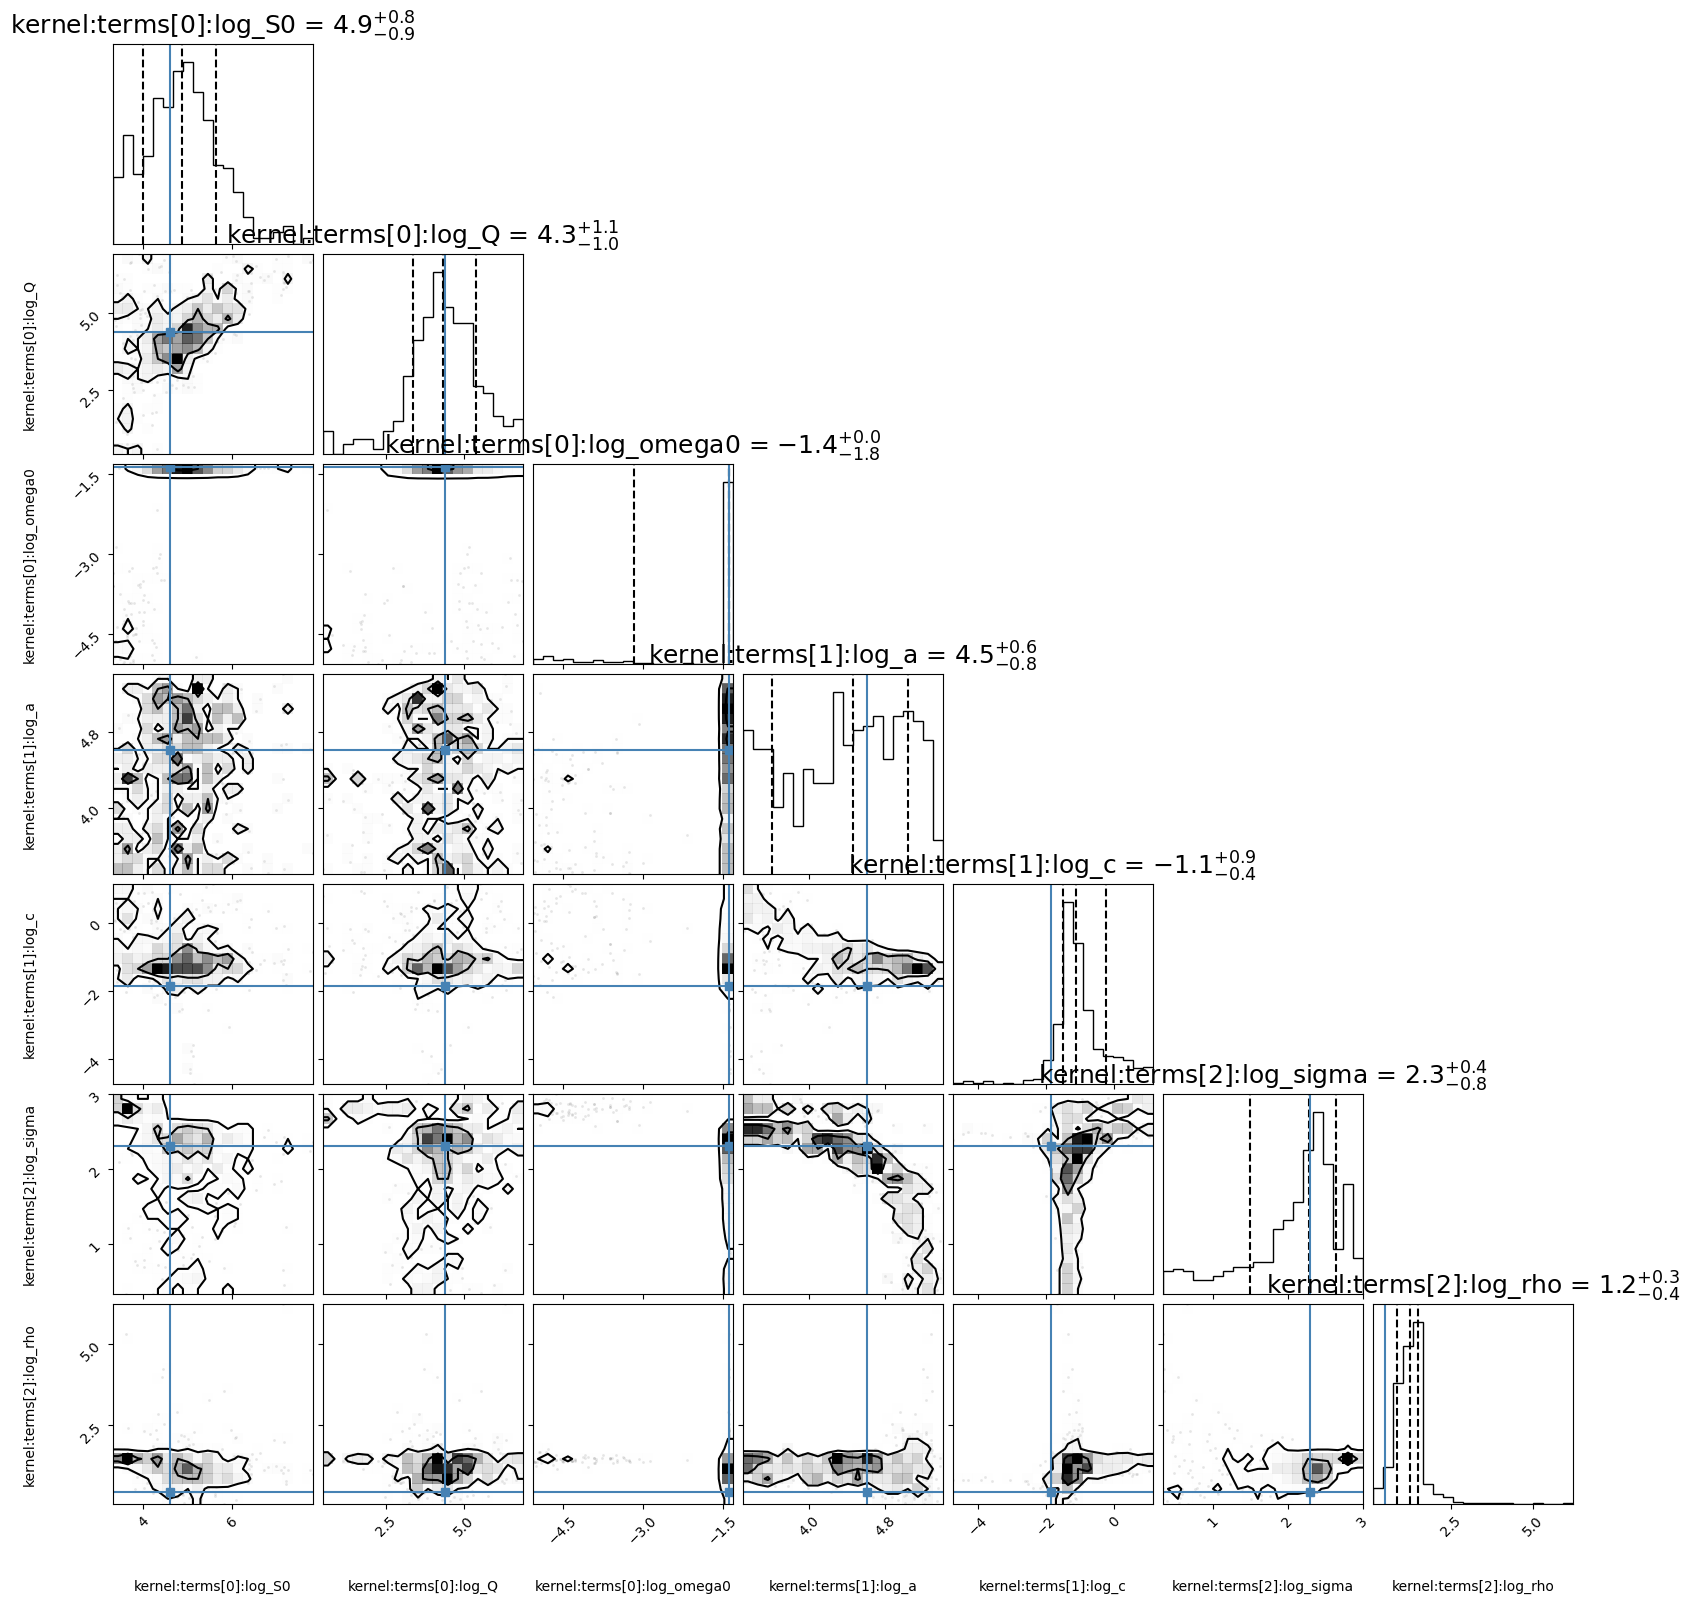

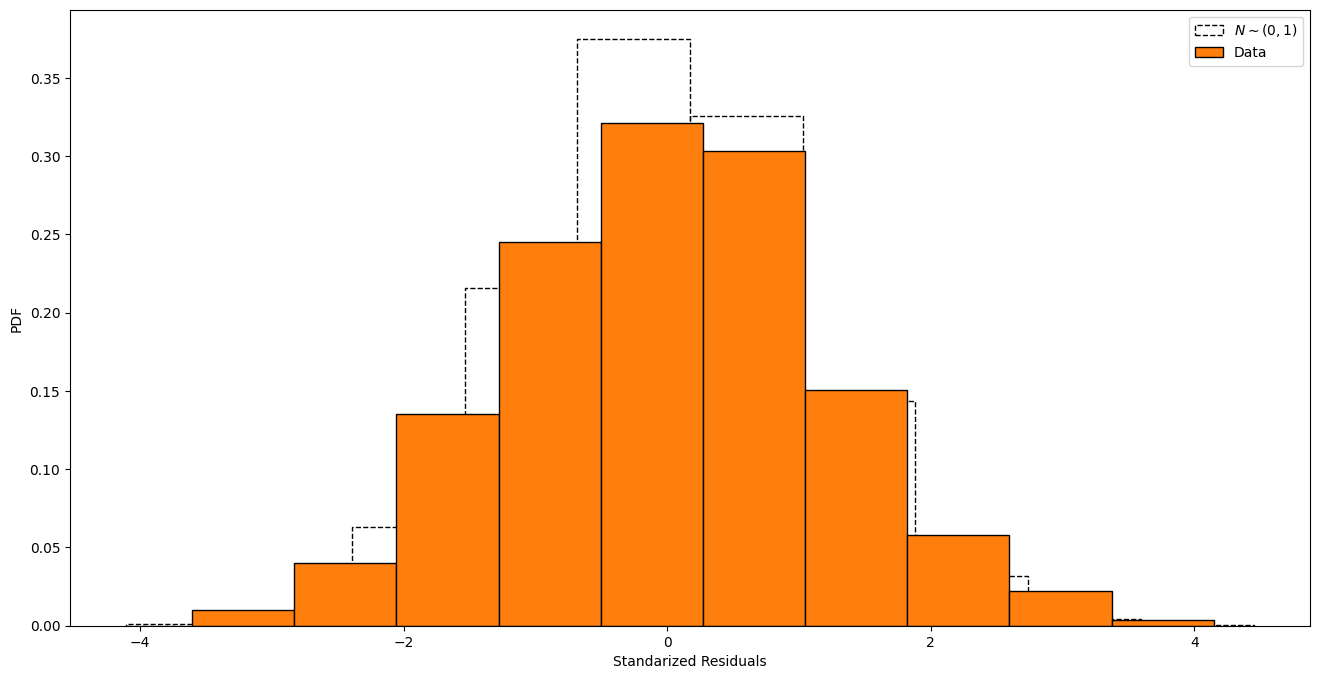

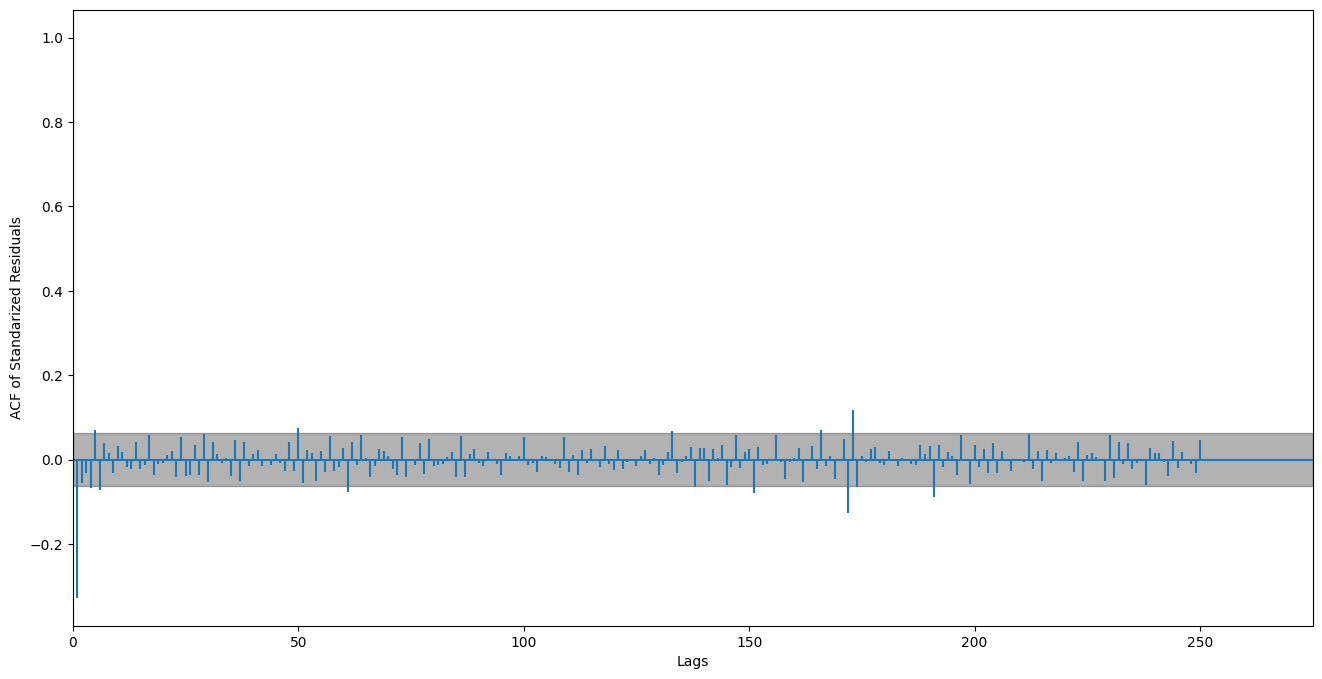

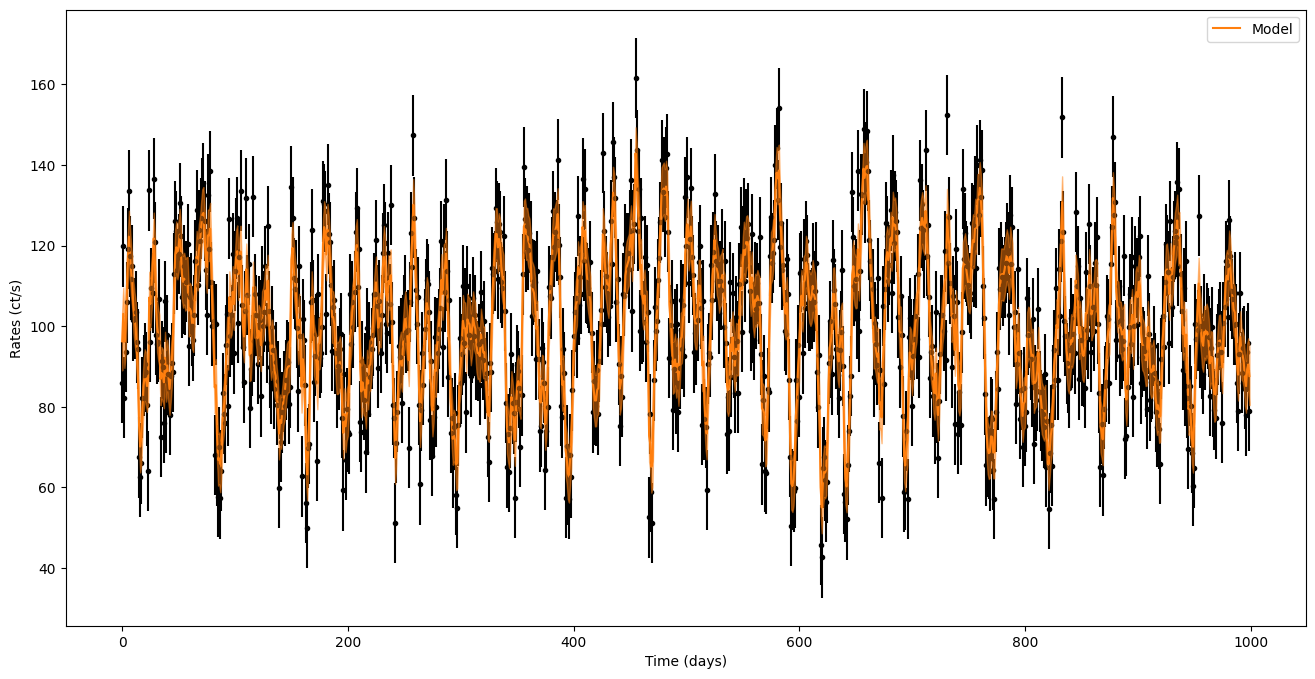

In [13]:
best_gp = gps[np.argmin(aiccs)]
print(best_gp.max_parameters)
print(f"Best model {models[np.argmin(aiccs)]} has a p-value: {pvalues[np.argmin(AICc)]:.3f}")
corner_fig = corner.corner(best_gp.mcmc_samples, labels=best_gp.parameter_names, 
                           title_fmt='.1f', truths=truth,
                            quantiles=[0.16, 0.5, 0.84], show_titles=True,
                            title_kwargs={"fontsize": 18}, max_n_ticks=3, labelpad=0.08,
                            levels=(1 - np.exp(-0.5), 1 - np.exp(-0.5 * 2 ** 2))) # plots 1 and 2 sigma levels

plt.savefig("corner.png")
# 
best_gp.parameters = gp.max_parameters
print(best_gp.parameters)
pred_mean, pred_var = gp.predict(input_lc.y, return_var=True)
 # standarized residuals
plt.figure()
std_res = gp.standarized_residuals()
plt.hist(norm.rvs(size=10000), edgecolor="black" , ls="--",
         facecolor="None", density=True, label="$N\sim(0, 1)$")
plt.hist(std_res, density="True", edgecolor="black", label="Data")
plt.xlabel("Standarized Residuals")
plt.ylabel("PDF")
plt.legend()
plt.savefig("std_res.png")
# ACF
plt.figure()
plt.acorr(std_res, maxlags=len(std_res) // 4 )
plt.xlim(0)
# 2 sigma
plt.axhspan(-1.96 / np.sqrt(len(std_res)), 1.96 / np.sqrt(len(std_res)), alpha=0.3, color="black")
plt.ylabel("ACF of Standarized Residuals")
plt.xlabel("Lags")
plt.savefig("acf.png")
# best-fit model
fig = plt.figure()
plt.errorbar(times, noisy_countrates, yerr=dy, ls="None", marker=".", color="black")
plt.xlabel("Time (days)")
plt.ylabel("Rates (ct/s)")
plt.plot(times, pred_mean, label="Model", color="C1")
plt.fill_between(times, pred_mean - np.sqrt(pred_var), pred_mean + np.sqrt(pred_var), 
                 zorder=10, color="C1", alpha=0.5)
plt.legend()
plt.savefig("model.png")